# <center>Comtrade Data Analysis

In [ ]:
import pandas as pd
import requests
import comtradeapicall
from datetime import date
from datetime import timedelta
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import networkx as nx


In [ ]:
# Access API key
API_KEY_FILE = 'COMTRADE_API_KEY.json'

try:
    with open(API_KEY_FILE, 'r') as f:
        api_config = json.load(f)
        subscription_key = api_config['SUBSCRIPTION_KEY']
    print("✓ API key loaded successfully")
except FileNotFoundError:
    print(f"❌ ERROR: {API_KEY_FILE} not found!")
    print(f"   Please create a JSON file with: {{\"SUBSCRIPTION_KEY\": \"your_key_here\"}}")
    raise
except KeyError:
    print(f"❌ ERROR: 'SUBSCRIPTION_KEY' not found in {API_KEY_FILE}")
    raise

In [6]:
today = date.today()
yesterday = today - timedelta(days=1)
lastweek = today - timedelta(days=7)

In [7]:
mydf = comtradeapicall.previewFinalData(typeCode='C', freqCode='M', clCode='HS', period='202205',
                                        reporterCode='36', cmdCode='91', flowCode='M', partnerCode=None,
                                        partner2Code=None,
                                        customsCode=None, motCode=None, maxRecords=500, format_output='JSON',
                                        aggregateBy=None, breakdownMode='classic', countOnly=None, includeDesc=True)

In [8]:
mydf.columns.tolist()

['typeCode',
 'freqCode',
 'refPeriodId',
 'refYear',
 'refMonth',
 'period',
 'reporterCode',
 'reporterISO',
 'reporterDesc',
 'flowCode',
 'flowDesc',
 'partnerCode',
 'partnerISO',
 'partnerDesc',
 'partner2Code',
 'partner2ISO',
 'partner2Desc',
 'classificationCode',
 'classificationSearchCode',
 'isOriginalClassification',
 'cmdCode',
 'cmdDesc',
 'aggrLevel',
 'isLeaf',
 'customsCode',
 'customsDesc',
 'mosCode',
 'motCode',
 'motDesc',
 'qtyUnitCode',
 'qtyUnitAbbr',
 'qty',
 'isQtyEstimated',
 'altQtyUnitCode',
 'altQtyUnitAbbr',
 'altQty',
 'isAltQtyEstimated',
 'netWgt',
 'isNetWgtEstimated',
 'grossWgt',
 'isGrossWgtEstimated',
 'cifvalue',
 'fobvalue',
 'primaryValue',
 'legacyEstimationFlag',
 'isReported',
 'isAggregate']

In [9]:
# Get full data using API key - Germany exports 2024
germany_exports = comtradeapicall.getFinalData(
    subscription_key=subscription_key,
    typeCode='C',           # Goods
    freqCode='A',           # Annual
    clCode='HS',            # Harmonized System
    period='2024',          # Year 2024
    reporterCode='276',     # Germany
    cmdCode='TOTAL',        # All commodities
    flowCode='X',           # Exports
    partnerCode=None,       # All partners
    partner2Code=None,
    customsCode=None,
    motCode=None,
    maxRecords=250000,      # Increased limit with API key
    format_output='JSON',
    aggregateBy=None,
    breakdownMode='classic',
    countOnly=None,
    includeDesc=True
)

{ "statusCode": 401, "message": "Access denied due to invalid subscription key. Make sure to provide a valid key for an active subscription." }


In [ ]:
# Get USA exports data for 2024
usa_exports = comtradeapicall.getFinalData(
    subscription_key=subscription_key,
    typeCode='C',           # Goods
    freqCode='A',           # Annual
    clCode='HS',            # Harmonized System
    period='2024',          # Year 2024
    reporterCode='842',     # USA
    cmdCode='TOTAL',        # All commodities
    flowCode='X',           # Exports
    partnerCode=None,       # All partners
    partner2Code=None,
    customsCode=None,
    motCode=None,
    maxRecords=250000,
    format_output='JSON',
    aggregateBy=None,
    breakdownMode='classic',
    countOnly=None,
    includeDesc=True
)

In [ ]:
# Get China exports data for 2024
china_exports = comtradeapicall.getFinalData(
    subscription_key=subscription_key,
    typeCode='C',           # Goods
    freqCode='A',           # Annual
    clCode='HS',            # Harmonized System
    period='2024',          # Year 2024
    reporterCode='156',     # China
    cmdCode='TOTAL',        # All commodities
    flowCode='X',           # Exports
    partnerCode=None,       # All partners
    partner2Code=None,
    customsCode=None,
    motCode=None,
    maxRecords=250000,
    format_output='JSON',
    aggregateBy=None,
    breakdownMode='classic',
    countOnly=None,
    includeDesc=True
)

In [ ]:
# Filter trade data between Germany (276), USA (842), and China (156)
import numpy as np

# Country codes mapping
countries = {
    'Germany': '276',
    'USA': '842', 
    'China': '156'
}

# Extract bilateral trade flows
trade_flows = []

# Germany to USA and China
germany_to_usa = germany_exports[germany_exports['partnerCode'] == 842]['primaryValue'].sum() if len(germany_exports[germany_exports['partnerCode'] == 842]) > 0 else 0
germany_to_china = germany_exports[germany_exports['partnerCode'] == 156]['primaryValue'].sum() if len(germany_exports[germany_exports['partnerCode'] == 156]) > 0 else 0

# USA to Germany and China  
usa_to_germany = usa_exports[usa_exports['partnerCode'] == 276]['primaryValue'].sum() if len(usa_exports[usa_exports['partnerCode'] == 276]) > 0 else 0
usa_to_china = usa_exports[usa_exports['partnerCode'] == 156]['primaryValue'].sum() if len(usa_exports[usa_exports['partnerCode'] == 156]) > 0 else 0

# China to Germany and USA
china_to_germany = china_exports[china_exports['partnerCode'] == 276]['primaryValue'].sum() if len(china_exports[china_exports['partnerCode'] == 276]) > 0 else 0
china_to_usa = china_exports[china_exports['partnerCode'] == 842]['primaryValue'].sum() if len(china_exports[china_exports['partnerCode'] == 842]) > 0 else 0

# Create trade flow matrix
trade_matrix = {
    'Germany_to_USA': germany_to_usa,
    'Germany_to_China': germany_to_china,
    'USA_to_Germany': usa_to_germany,
    'USA_to_China': usa_to_china,
    'China_to_Germany': china_to_germany,
    'China_to_USA': china_to_usa
}

print("Trade flows (in USD):")
for flow, value in trade_matrix.items():
    print(f"{flow}: ${value:,.0f}")

Trade flows (in USD):
Germany_to_USA: $175,528,388,461
Germany_to_China: $97,733,536,224
USA_to_Germany: $75,381,806,630
USA_to_China: $143,545,716,168
China_to_Germany: $107,059,114,975
China_to_USA: $525,648,764,497


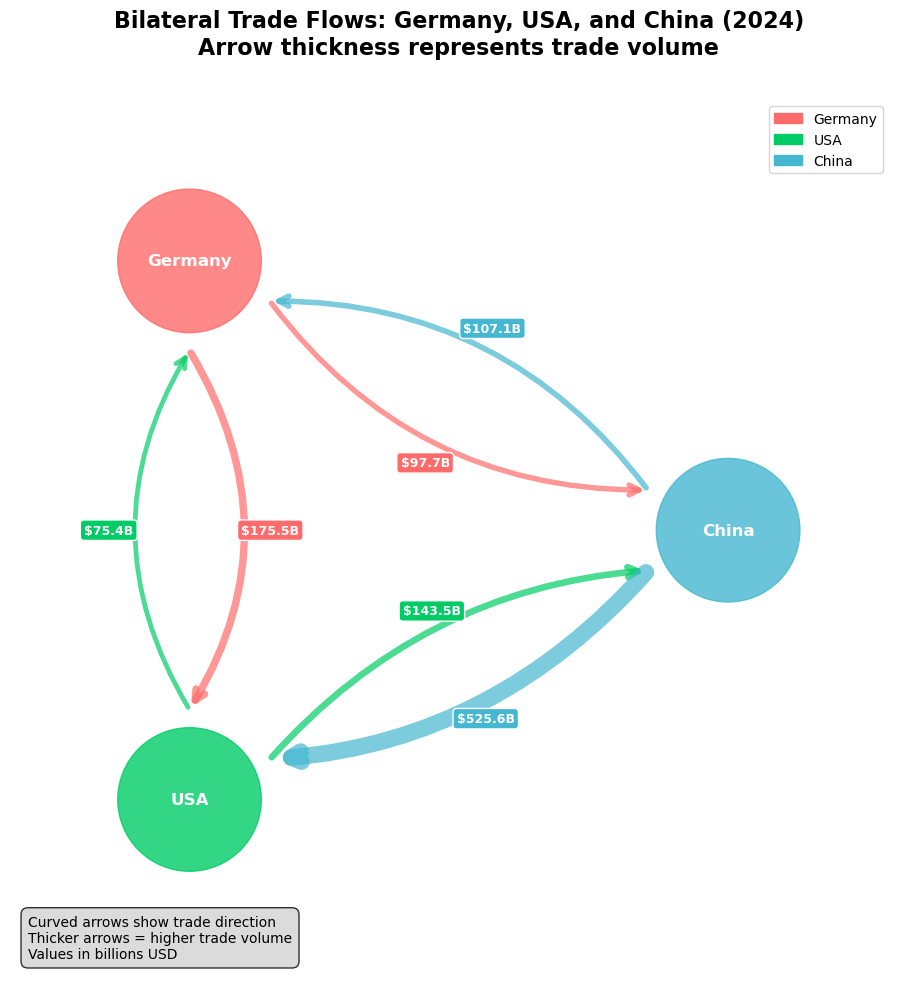

Trade Flow Summary (Billions USD):
Germany → USA: $175.5B
USA → Germany: $75.4B
Germany → China: $97.7B
China → Germany: $107.1B
USA → China: $143.5B
China → USA: $525.6B


In [ ]:
# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Define country positions (forming a triangle)
positions = {
    'Germany': (0.2, 0.8),
    'USA': (0.2, 0.2),
    'China': (0.8, 0.5)
}

# Define colors for each country
colors = {
    'Germany': '#FF6B6B',  # Red
    'USA': '#00CC66',      # Bright Green  
    'China': '#45B7D1'     # Blue
}

# Draw country circles
circle_radius = 0.08
for country, (x, y) in positions.items():
    circle = Circle((x, y), circle_radius, color=colors[country], alpha=0.8, zorder=3)
    ax.add_patch(circle)
    ax.text(x, y, country, ha='center', va='center', fontsize=12, fontweight='bold', 
            color='white', zorder=4)

# Normalize trade flows for arrow widths
max_trade = max(trade_matrix.values())
min_width = 2
max_width = 12

def get_arrow_width(value):
    return min_width + (max_width - min_width) * (value / max_trade)

# Function to create curved arrow and calculate the exact center of the curve
def create_curved_arrow_with_label_pos(start_pos, end_pos, trade_value, curve_offset=0.15, color='darkgray'):
    x1, y1 = start_pos
    x2, y2 = end_pos
    
    # Calculate direction vector and normalize
    dx = x2 - x1
    dy = y2 - y1
    distance = np.sqrt(dx**2 + dy**2)
    
    # Adjust start and end points to circle edges
    edge_offset = circle_radius + 0.02
    start_x = x1 + (dx/distance) * edge_offset
    start_y = y1 + (dy/distance) * edge_offset
    end_x = x2 - (dx/distance) * edge_offset
    end_y = y2 - (dy/distance) * edge_offset
    
    # Create the curved arrow
    arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                           connectionstyle=f"arc3,rad={curve_offset}",
                           arrowstyle='->', 
                           mutation_scale=18,
                           linewidth=get_arrow_width(trade_value),
                           color=color,
                           alpha=0.7,
                           zorder=2)
    
    # Calculate the midpoint of the straight line between arrow endpoints
    mid_x = (start_x + end_x) / 2
    mid_y = (start_y + end_y) / 2
    
    # Calculate perpendicular direction for the curve
    perp_x = -dy / distance
    perp_y = dx / distance
    
    # Calculate the center of the curved path (where the label should go)
    # This uses the same math as matplotlib's arc3 connectionstyle
    label_x = mid_x + perp_x * curve_offset * distance * 0.5
    label_y = mid_y + perp_y * curve_offset * distance * 0.5
    
    return arrow, (label_x, label_y)

# Create all arrows with different offsets to prevent overlap
arrows_and_labels = []

# Germany ↔ USA - store label positions separately
germany_usa_arrow, germany_usa_label_pos = create_curved_arrow_with_label_pos(positions['Germany'], positions['USA'], 
                                                     trade_matrix['Germany_to_USA'], 
                                                     curve_offset=-0.3, color=colors['Germany'])
ax.add_patch(germany_usa_arrow)

usa_germany_arrow, usa_germany_label_pos = create_curved_arrow_with_label_pos(positions['USA'], positions['Germany'], 
                                                     trade_matrix['USA_to_Germany'], 
                                                     curve_offset=-0.3, color=colors['USA'])
ax.add_patch(usa_germany_arrow)

# Add labels on opposite arrows
arrows_and_labels.append((usa_germany_label_pos, f"${trade_matrix['Germany_to_USA']/1e9:.1f}B", colors['Germany']))
arrows_and_labels.append((germany_usa_label_pos, f"${trade_matrix['USA_to_Germany']/1e9:.1f}B", colors['USA']))

# Germany ↔ China - store label positions separately
germany_china_arrow, germany_china_label_pos = create_curved_arrow_with_label_pos(positions['Germany'], positions['China'], 
                                                         trade_matrix['Germany_to_China'], 
                                                         curve_offset=0.25, color=colors['Germany'])
ax.add_patch(germany_china_arrow)

china_germany_arrow, china_germany_label_pos = create_curved_arrow_with_label_pos(positions['China'], positions['Germany'], 
                                                         trade_matrix['China_to_Germany'], 
                                                         curve_offset=0.25, color=colors['China'])
ax.add_patch(china_germany_arrow)

# Add labels on opposite arrows
arrows_and_labels.append((china_germany_label_pos, f"${trade_matrix['Germany_to_China']/1e9:.1f}B", colors['Germany']))
arrows_and_labels.append((germany_china_label_pos, f"${trade_matrix['China_to_Germany']/1e9:.1f}B", colors['China']))

# USA ↔ China - store label positions separately
usa_china_arrow, usa_china_label_pos = create_curved_arrow_with_label_pos(positions['USA'], positions['China'], 
                                                     trade_matrix['USA_to_China'], 
                                                     curve_offset=-0.2, color=colors['USA'])
ax.add_patch(usa_china_arrow)

china_usa_arrow, china_usa_label_pos = create_curved_arrow_with_label_pos(positions['China'], positions['USA'], 
                                                     trade_matrix['China_to_USA'], 
                                                     curve_offset=-0.2, color=colors['China'])
ax.add_patch(china_usa_arrow)

# Add labels on opposite arrows
arrows_and_labels.append((china_usa_label_pos, f"${trade_matrix['USA_to_China']/1e9:.1f}B", colors['USA']))
arrows_and_labels.append((usa_china_label_pos, f"${trade_matrix['China_to_USA']/1e9:.1f}B", colors['China']))

# Add labels at the calculated positions
for (x, y), label, bg_color in arrows_and_labels:
    ax.text(x, y, label, ha='center', va='center', fontsize=9, fontweight='bold',
            color='white',
            bbox=dict(boxstyle="round,pad=0.3", facecolor=bg_color, alpha=1.0, edgecolor='white'),
            zorder=5)

# Set axis properties
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')

# Add title
plt.title('Bilateral Trade Flows: Germany, USA, and China (2024)\nArrow thickness represents trade volume', 
          fontsize=16, fontweight='bold', pad=20)

# Create legend for countries
legend_elements = [mpatches.Patch(color=colors[country], label=country) 
                  for country in ['Germany', 'USA', 'China']]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

# Add explanation
ax.text(0.02, 0.02, 'Curved arrows show trade direction\nThicker arrows = higher trade volume\nValues in billions USD', 
        fontsize=10, ha='left', va='bottom', 
        bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# Print trade summary
print("Trade Flow Summary (Billions USD):")
print("="*50)
print(f"Germany → USA: ${trade_matrix['Germany_to_USA']/1e9:.1f}B")
print(f"USA → Germany: ${trade_matrix['USA_to_Germany']/1e9:.1f}B")
print(f"Germany → China: ${trade_matrix['Germany_to_China']/1e9:.1f}B") 
print(f"China → Germany: ${trade_matrix['China_to_Germany']/1e9:.1f}B")
print(f"USA → China: ${trade_matrix['USA_to_China']/1e9:.1f}B")
print(f"China → USA: ${trade_matrix['China_to_USA']/1e9:.1f}B")

Top 22 countries by total trade volume:
1. Ukraine: $11.9B
2. France: $9.9B
3. Spain: $9.8B
4. Italy: $6.7B
5. Romania: $6.1B
6. Turkey: $5.6B
7. Algeria: $3.9B
8. Egypt: $3.2B
9. Morocco: $2.9B
10. Tunisia: $1.4B
11. Greece: $1.2B
12. Libya: $0.9B
13. Lebanon: $0.7B
14. Slovenia: $0.7B
15. Israel: $0.6B
16. Croatia: $0.6B
17. Cyprus: $0.3B
18. Russia: $0.1B
19. Albania: $0.1B
20. Malta: $0.1B
21. Bosnia Herzegovina: $0.1B
22. Montenegro: $0.0B


/var/folders/3d/fbytqdpn2m599fcr4p1zr9_h0000gn/T/ipykernel_22742/113730707.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('hsv')


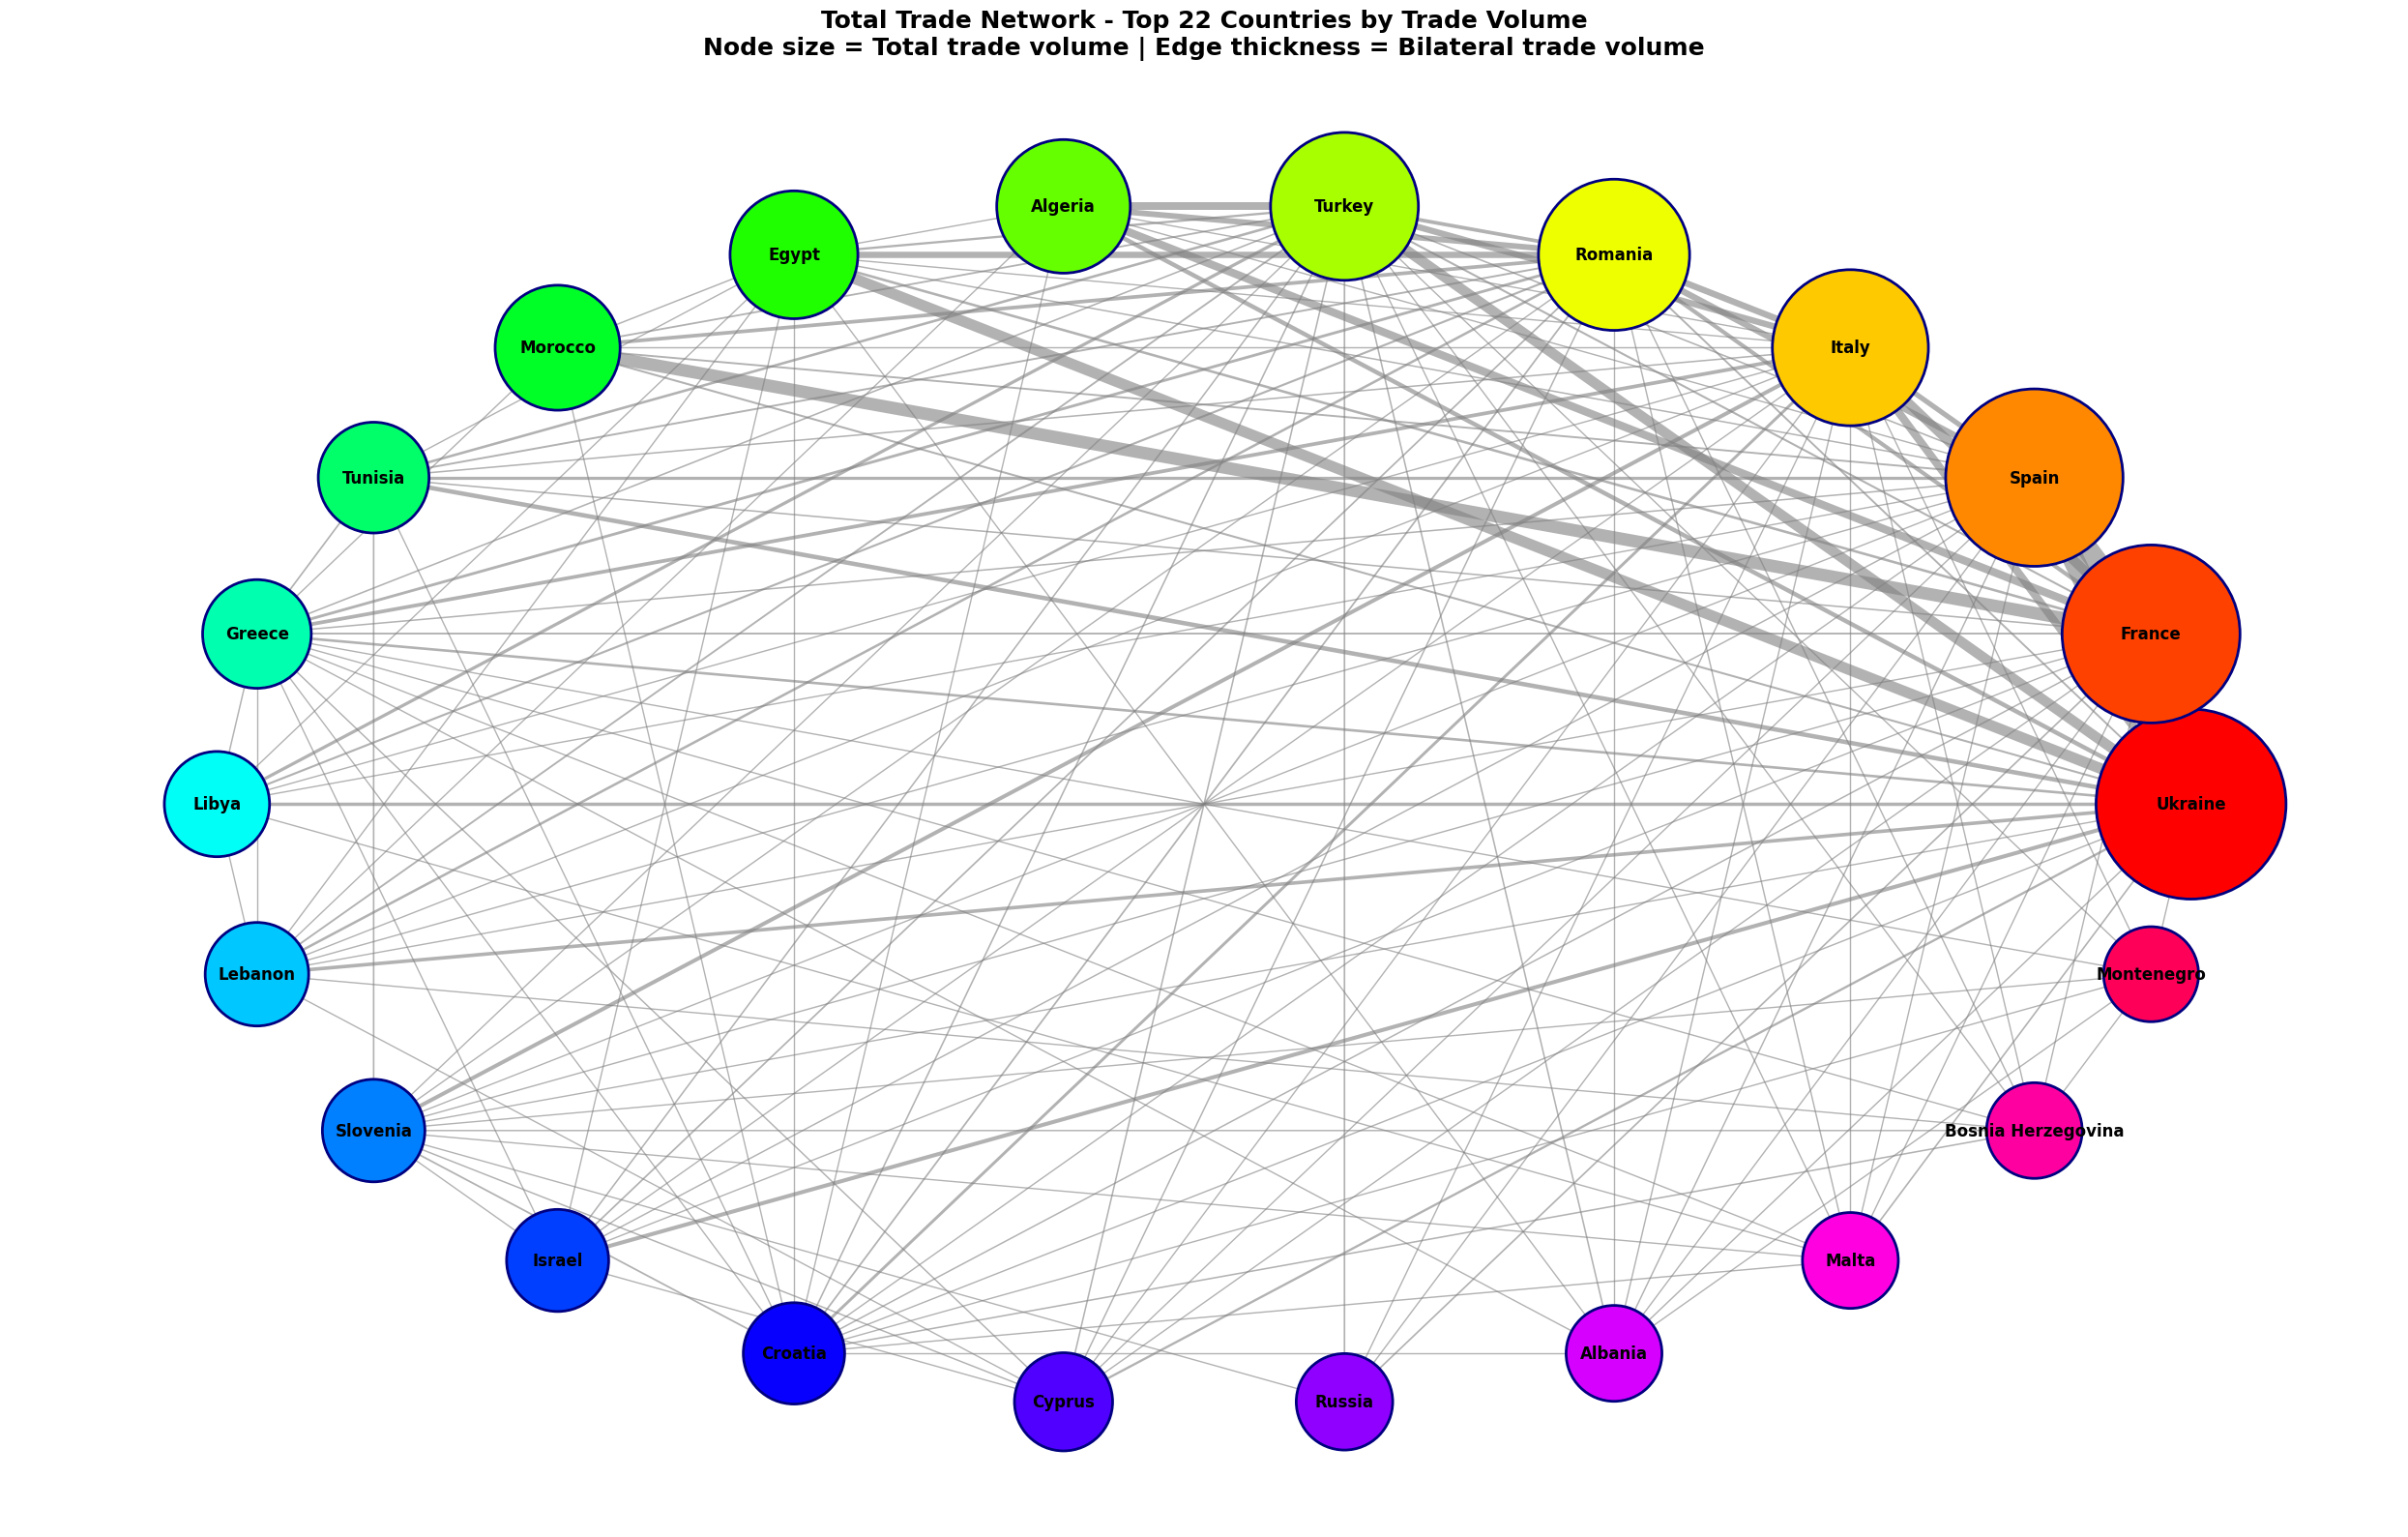


Graph statistics:
Number of nodes: 22
Number of edges: 145
Network density: 0.628


In [ ]:
# Load the trade matrix from CSV
trade_matrix_df = pd.read_csv('data/all_trade_matrices/trade_matrix_all_transport_modes_HS10.csv', index_col=0)

# Parameter: number of top trading countries to visualize
TOP_N_COUNTRIES = 22

# Calculate total trade volume for each country (exports + imports)
# Use the "World" column/row which contains the totals
country_total_trade = {}
for country in trade_matrix_df.index:
    if country == 'World':
        continue  # Skip "World" as a country
    if country in trade_matrix_df.columns and 'World' in trade_matrix_df.columns:
        # Total exports to World + total imports from World
        exports = trade_matrix_df.loc[country, 'World']
        imports = trade_matrix_df.loc['World', country]
        country_total_trade[country] = exports + imports

# Get top N countries by total trade volume
top_countries = sorted(country_total_trade.items(), key=lambda x: x[1], reverse=True)[:TOP_N_COUNTRIES]
top_country_names = [c[0] for c in top_countries]

print(f"Top {TOP_N_COUNTRIES} countries by total trade volume:")
for i, (country, volume) in enumerate(top_countries, 1):
    print(f"{i}. {country}: ${volume/1e9:.1f}B")

# Create undirected graph
G = nx.Graph()

# Add nodes with size based on total trade volume
node_sizes = {}
for country, volume in top_countries:
    G.add_node(country)
    node_sizes[country] = volume

# Add edges with weight based on total trade between countries (both directions)
edge_weights = {}
for i, country1 in enumerate(top_country_names):
    for country2 in top_country_names[i+1:]:  # Only process each pair once
        if country1 == 'World' or country2 == 'World':
            continue  # Skip edges involving "World"
        
        # Get trade in both directions and sum
        trade_1_to_2 = trade_matrix_df.loc[country1, country2] if country2 in trade_matrix_df.columns else 0
        trade_2_to_1 = trade_matrix_df.loc[country2, country1] if country1 in trade_matrix_df.columns else 0
        total_trade = trade_1_to_2 + trade_2_to_1
        
        if total_trade > 0:
            G.add_edge(country1, country2, weight=total_trade)
            edge_weights[(country1, country2)] = total_trade

# Create visualization
plt.figure(figsize=(25, 16))

# Use circular layout for evenly spaced nodes
pos = nx.circular_layout(G)

# Generate unique colors for each node using a continuous colormap
# This supports any number of countries
colormap = cm.get_cmap('hsv')
node_colors = [colormap(i / len(G.nodes())) for i in range(len(G.nodes()))]

# Calculate node sizes (scale to reasonable bubble sizes)
max_trade = max(node_sizes.values())
min_trade = min(node_sizes.values())
node_size_list = [5000 + 15000 * (node_sizes[node] - min_trade) / (max_trade - min_trade) for node in G.nodes()]

# Calculate edge widths (scale based on trade volume)
if edge_weights:
    max_edge_weight = max(edge_weights.values())
    min_edge_weight = min(edge_weights.values())
    edge_width_list = [1 + 15 * (edge_weights.get((u, v), edge_weights.get((v, u), 0)) - min_edge_weight) / 
                       (max_edge_weight - min_edge_weight) 
                       for u, v in G.edges()]
else:
    edge_width_list = [1] * len(G.edges())

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=node_size_list, node_color=node_colors, 
                       alpha=1.0, edgecolors='navy', linewidths=2)

nx.draw_networkx_edges(G, pos, width=edge_width_list, alpha=0.6, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title(f'Total Trade Network - Top {TOP_N_COUNTRIES} Countries by Trade Volume\n' + 
          'Node size = Total trade volume | Edge thickness = Bilateral trade volume', 
          fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nGraph statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.3f}")

In [ ]:
np.sum(trade_matrix_df.iloc[1:, 1:].values.flatten() == 0)/(243*242)

np.int64(43451)